In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom
import matplotlib

In [2]:
bp_table = np.zeros((3, 4, 32, 4)) # 4 cases, 4 sessions, 32 channels, 4 frequency bands
se_table = np.zeros((3, 4, 32, 4))
num_table = np.zeros((3, 4, 32, 4))

freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]

case_title = 'Fix'
case = 'all'
fs = 1200
tmax = 1.5
watch = '1 fixation'
tmin = 0 # include fix or not?

highpass = None
lowpass = None

sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)

interval = [0, 1.5]
t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
sessions = [sb, sa, rb, ra]

for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i, session in enumerate(sessions):
            tmp = np.empty(())
            data = session[channel]
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
            bp = fe.band_power(psds, freqs, band)
            tmp = np.append(tmp, bp)
            tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)

            se_table[0, i, channel, k] = np.std(tmp)/np.sqrt(len(tmp))
            bp_table[0, i, channel, k] = np.mean(tmp)
            num_table[0, i, channel, k] = len(tmp)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)


In [3]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_titles = ['endo', 'exo']

for case_num, case_title in enumerate(case_titles):
    case_list = [case_title+' fast', case_title+' slow']
    if 'endo' in case_title:
        tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
    else:
        tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

    fs = 1200
    for i, case in enumerate(case_list):
        tmax = tmax_list[i]
        watch = '1 fixation'
        tmin = 0 # include fix or not?

        highpass = None
        lowpass = None

        sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
        
        if 'slow' in case:
            # sham_before_slow = align_slow(sb, case, fs)
            # sham_after_slow = align_slow(sa, case, fs)
            # real_before_slow = align_slow(rb, case, fs)
            # real_after_slow = align_slow(ra, case, fs)

            sham_before_slow = sb
            sham_after_slow = sa
            real_before_slow = rb
            real_after_slow = ra

        else:
            sham_before_fast = sb
            sham_after_fast = sa
            real_before_fast = rb
            real_after_fast = ra

    # exclude fixation
    endo_fast_interval = [1.5, 1.5+1+0.5+0.05+0.2]
    endo_slow_interval = [1.5, 1.5+1+0.5+0.05+0.2]
    #endo_slow_interval = [1.5, 1.5+1+1+0.05+0.2]
    exo_fast_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
    exo_slow_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
    # exo_slow_interval = [1.5, 1.5+0.033*4+1+0.05+0.2]

    if 'endo' in case_title:
        intervals = [endo_fast_interval, endo_slow_interval]
    else:
        intervals = [exo_fast_interval, exo_slow_interval]

    slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
    fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

    for channel in range(32):
        for k, band in enumerate(freq_bands):
            for i in range(4):
                fast_session = fast_sessions[i][channel]
                slow_session = slow_sessions[i][channel]
                tmp = np.empty(())
                for j, data in enumerate([fast_session, slow_session]):
                    interval = intervals[j]
                    t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                    psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                    bp = fe.band_power(psds, freqs, band)
                    tmp = np.append(tmp, bp)
                tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=False)
                se_table[case_num+1, i, channel, k] = np.std(tmp)/np.sqrt(len(tmp))
                bp_table[case_num+1, i, channel, k] = np.mean(tmp)
                num_table[case_num+1, i, channel, k] = len(tmp)

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tes-attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_

In [4]:
bp_subtracts = np.zeros((3, 2, 32, 4))
bp_subtracts_norm = np.zeros((3, 2, 32, 4))
bp_subtracts[:,0,:,:] = bp_table[:,1,:,:] - bp_table[:,0,:,:]
bp_subtracts[:,1,:,:] = bp_table[:,3,:,:] - bp_table[:,2,:,:]
bp_subtracts_norm[:,0,:,:] = bp_subtracts[:,0,:,:] / bp_table[:,0,:,:]
bp_subtracts_norm[:,1,:,:] = bp_subtracts[:,1,:,:] / bp_table[:,2,:,:]

# https://www.graphpad.com/support/faq/the-standard-error-of-the-difference-between-two-means/#:~:text=The%20standard%20error%20for%20the,is%20less%20than%20their%20sum.
se_subtracts = np.zeros((3, 2, 32, 4))
se_subtracts[:,0,:,:] = np.sqrt(se_table[:,0,:,:]**2 + se_table[:,1,:,:]**2)
se_subtracts[:,1,:,:] = np.sqrt(se_table[:,2,:,:]**2 + se_table[:,3,:,:]**2)
num_subtracts = np.zeros((3, 2, 32, 4))
num_subtracts[:,0,:,:] = num_table[:,0,:,:] + num_table[:,1,:,:]
num_subtracts[:,1,:,:] = num_table[:,2,:,:] + num_table[:,3,:,:]

sham_increase_channel_list = [[],[],[],[]]
sham_decrease_channel_list = [[],[],[],[]]
real_increase_channel_list = [[],[],[],[]]
real_decrease_channel_list = [[],[],[],[]]

bp_subtracts_positive = np.where(bp_subtracts>0, 1, 0)
bp_subtracts_negative = np.where(bp_subtracts<0, 1, 0)
for band in range (4):
    sham_positive = bp_subtracts_positive[0, 0, :, band] * bp_subtracts_positive[1, 0, :, band] * bp_subtracts_positive[2, 0, :, band]
    sham_negative = bp_subtracts_negative[0, 0, :, band] * bp_subtracts_negative[1, 0, :, band] * bp_subtracts_negative[2, 0, :, band]
    real_positive = bp_subtracts_positive[0, 1, :, band] * bp_subtracts_positive[1, 1, :, band] * bp_subtracts_positive[2, 1, :, band]
    real_negative = bp_subtracts_negative[0, 1, :, band] * bp_subtracts_negative[1, 1, :, band] * bp_subtracts_negative[2, 1, :, band]
    sham_increase_channel_list[band] = np.where(sham_positive==1)[0]
    sham_decrease_channel_list[band] = np.where(sham_negative==1)[0]
    real_increase_channel_list[band] = np.where(real_positive==1)[0]
    real_decrease_channel_list[band] = np.where(real_negative==1)[0]

In [27]:
[x+1 for x in real_increase_channel_list[3]]

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 18, 24, 26, 27, 28, 29, 31, 32]

In [28]:
[x+1 for x in real_decrease_channel_list[3]]

[12, 16, 17, 20, 21, 22, 23]

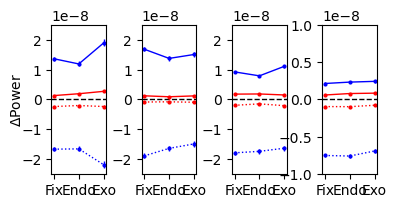

In [5]:
def calculate_grand_mean_and_se(means, ses, sample_sizes):
     # Number of cases is the number of rows in the input arrays
    num_cases = means.shape[0]

    # Initialize arrays to store the grand mean and standard error for each case
    grand_means = np.zeros(num_cases)
    grand_ses = np.zeros(num_cases)

    for i in range(num_cases):
        # Calculate the grand mean for this case
        grand_means[i] = np.mean(means[i, :])
        
        # Calculate the weighted sum of squared standard errors for this case
        weighted_ses_squared = np.sum((sample_sizes[i, :] - 1) * ses[i, :]**2)
        
        # Calculate the total degrees of freedom for this case
        total_degrees_of_freedom = np.sum(sample_sizes[i, :] - 1)
        
        # Calculate the weighted variance for this case
        weighted_variance = weighted_ses_squared / total_degrees_of_freedom
        
        # Calculate the standard error of the grand mean for this case
        grand_ses[i] = np.sqrt(weighted_variance / means.shape[1])
    
    return grand_means, grand_ses


# Set up the figure and axes
band_names = ['theta', 'alpha', 'beta', 'gamma']
case_names = ['Fix', 'Endo', 'Exo']
ylims = [[-2.5e-8, 2.5e-8], [-2.5e-8, 2.5e-8], [-2.5e-8, 2.5e-8], [-1e-8, 1e-8]]
subtract_threshold = [0.25e-8, 0.25e-8, 0.25e-8, 0.25e-8]

cm = 1/2.54
fig, axes = plt.subplots(nrows=1, ncols=len(band_names), figsize=(9.4*cm, 5*cm))
line_width = 1
marker_size = 2
for band, band_name in enumerate(band_names):
    ax = axes[band]
    # sham power increase
    sham_increase_channels = sham_increase_channel_list[band]
    sham_increase = bp_subtracts[:,0,sham_increase_channels,band]
    sham_increase_by_case, se_grand  = calculate_grand_mean_and_se(sham_increase, se_subtracts[:,0,sham_increase_channels,band], num_subtracts[:,0,sham_increase_channels,band])
    ax.errorbar(case_names, sham_increase_by_case, yerr=se_grand, color='blue', label='Sham increase', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)

    # sham power decrease
    sham_decrease_channels = sham_decrease_channel_list[band]
    sham_decrease = bp_subtracts[:,0,sham_decrease_channels,band]
    sham_decrease_by_case, se_grand  = calculate_grand_mean_and_se(sham_decrease, se_subtracts[:,0,sham_decrease_channels,band], num_subtracts[:,0,sham_decrease_channels,band])
    ax.errorbar(case_names, sham_decrease_by_case, yerr=se_grand, color='blue', label='Sham decrease', marker='o', linestyle=':', linewidth = line_width, markersize=marker_size)

    # real power increase
    real_increase_channels = real_increase_channel_list[band]
    real_increase = bp_subtracts[:,1,real_increase_channels,band]
    real_increase_by_case, se_grand  = calculate_grand_mean_and_se(real_increase, se_subtracts[:,1,real_increase_channels,band], num_subtracts[:,1,real_increase_channels,band])
    ax.errorbar(case_names, real_increase_by_case, yerr=se_grand, color='red', label='Real increase', marker='o', linestyle='-', linewidth = line_width, markersize=marker_size)

    # real power decrease
    real_decrease_channels = real_decrease_channel_list[band]
    real_decrease = bp_subtracts[:,1,real_decrease_channels,band]
    real_decrease_by_case, se_grand  = calculate_grand_mean_and_se(real_decrease, se_subtracts[:,1,real_decrease_channels,band], num_subtracts[:,1,real_decrease_channels,band])
    ax.errorbar(case_names, real_decrease_by_case, yerr=se_grand, color='red', label='Real decrease', marker='o', linestyle=':', linewidth = line_width, markersize=marker_size)

    ax.axhline(y=0, color='black', linestyle='--', linewidth = line_width)
    ax.set_ylim(ylims[band])
    # ax.set_xlabel('Trial type')
    ax.set_ylabel('Band power increase')
    if band == 3:
        ax.set_yticks([-1e-8, -0.5e-8, 0, 0.5e-8, 1e-8])
    # ax.set_title(band_name)

    if band == 0:
        ax.set_ylabel('$\u0394$Power', labelpad=-2)
    else:
        ax.set_ylabel('')  # Clear the y-axis label

plt.subplots_adjust(wspace=0.65)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.1, bottom=0.11, right=0.98, top=0.87)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 4', 'line_charts.eps')
# plt.savefig(save_path, format='eps')
plt.show()
